# Load data

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

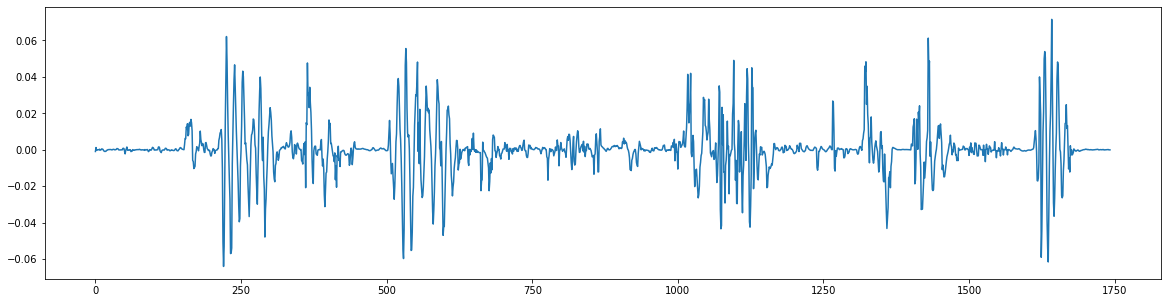

In [2]:
data_hand = np.loadtxt('dataset/a1va3.txt')[1:,1]
plt.figure(figsize=(20,5))
plt.plot(data_hand)
plt.show()

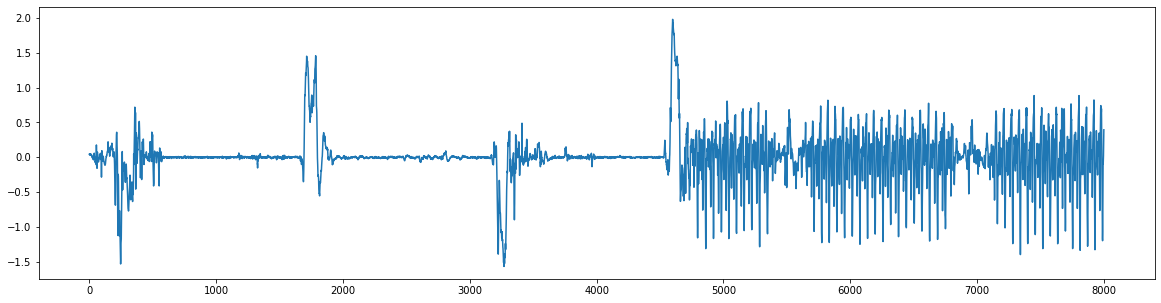

In [3]:
data_hip = np.loadtxt('dataset/gyroexp61user30_selected.txt')
plt.figure(figsize=(20,5))
plt.plot(data_hip)
plt.show()

# Calculate directely

In [11]:
from tslearn import metrics
import time

In [9]:
# Calculate DTW distance between A and B
def dtw_distance(A, B, w):
    # time series A and B, warping window size w
    dis = metrics.dtw(A, B, global_constraint="sakoe_chiba", sakoe_chiba_radius=w)
    return dis

In [20]:
# Using DTW to calculate matrix profile
# Here is a simple version. Furthur we can use FFT to speed up
def ComputeMatrixProfile_DTW_simple(T, L, w):
    #time series T, subsequence length L
    DTW_mp = 100 * np.ones(len(T)-L+1)
    DTW_index = -1 * np.ones_like(DTW_mp).astype('int')
    for i in tqdm(range(len(DTW_mp))):
        for j in range(len(DTW_mp)):
            if abs(i-j)<L: continue
            dis = dtw_distance(T[i:i+L], T[j:j+L], w)
            if dis < DTW_mp[i]:
                DTW_mp[i] = dis
                DTW_index[i] = j
    return DTW_mp, DTW_index

In [21]:
start = time.time()

DTW_mp, DTW_index = ComputeMatrixProfile_DTW_simple(data_hand, L=160, w=8)

stop = time.time()

print('\t time {:.4f}'.format(stop - start))

  0%|          | 0/1584 [00:00<?, ?it/s]

	 time 284.8409


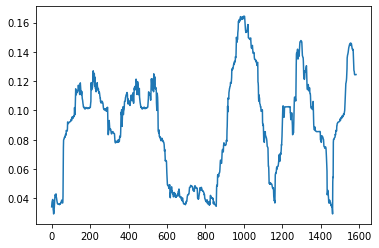

In [22]:
plt.plot(DTW_mp)